In [39]:
%matplotlib inline
import numpy as np
import pandas as pd

units = 1000
time_steps = 52

Z = np.random.normal(size=units)

a_trend = np.arange(0, time_steps, 1)
individual_effects = Z
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_trend + A_indiv


In [40]:
# we have a linear time trend
a_trend

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [41]:
A_trend # the same time trend for all units

array([[ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51],
       ...,
       [ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51],
       [ 0,  1,  2, ..., 49, 50, 51]])

In [42]:
# we have individual offsets
individual_effects

array([-8.93253339e-01, -1.09666136e+00,  4.27353642e-01,  1.44520048e+00,
        4.38795580e-01,  8.96686700e-01,  1.62119252e+00, -1.30064478e-01,
       -4.43165568e-01, -2.04901639e+00, -1.54718680e+00,  1.40305500e+00,
        1.41225225e+00, -1.00809407e+00,  5.68498727e-02, -8.71405945e-01,
        2.42546781e-01, -3.07400432e+00, -3.85623050e-01, -1.58357690e-02,
        2.65091453e-02,  2.00074199e-01,  5.51215775e-02,  6.83305971e-01,
       -7.85775243e-01, -1.74420000e+00,  5.51176439e-01,  1.19879365e+00,
        3.32426382e-01, -1.06984475e+00, -2.30336948e-01,  2.66790330e-01,
        6.93669309e-01,  3.38674913e-01,  5.98768624e-01, -5.51166254e-01,
        6.57236613e-01, -7.31142267e-01, -9.25339620e-01,  5.81513510e-02,
        4.65697985e-02,  5.34033238e-01,  4.09487287e-01, -3.76007676e-01,
        9.45804019e-01,  1.38889499e+00, -1.22255234e+00, -2.48003678e-01,
       -2.40529171e-02, -5.90648158e-01,  1.28590070e+00, -1.14338493e+00,
       -5.20295164e-01,  

In [43]:
A_indiv # the same offset of all time (but different for each unit)

array([[-0.89325334, -0.89325334, -0.89325334, ..., -0.89325334,
        -0.89325334, -0.89325334],
       [-1.09666136, -1.09666136, -1.09666136, ..., -1.09666136,
        -1.09666136, -1.09666136],
       [ 0.42735364,  0.42735364,  0.42735364, ...,  0.42735364,
         0.42735364,  0.42735364],
       ...,
       [ 1.53075471,  1.53075471,  1.53075471, ...,  1.53075471,
         1.53075471,  1.53075471],
       [-1.44499589, -1.44499589, -1.44499589, ..., -1.44499589,
        -1.44499589, -1.44499589],
       [ 1.11394801,  1.11394801,  1.11394801, ...,  1.11394801,
         1.11394801,  1.11394801]])

The outcome is the sum of a time trend and individual effects.

In [44]:
# Now, we'll have the probability of being assigned to treatment depend on Z
p_d = 1. / (1. + np.exp(-Z))
D_star = np.random.binomial(1, p=p_d)

# We need the time-series treatment assignments now. The treatment turns on and
# stays on. Let's start by having them all turn on at the same time, to build some
# intuition. Then we'll turn them on at random times. 
#
# The assignment matrix has the same dimensions as the outcome matrix.

D = np.zeros(shape=Y_0.shape)
for i in range(units):
    for t in range(time_steps):
        if D_star[i] and t > 0:
            if t == time_steps - 1 or D[i][t-1] == 1:
                D[i][t] = 1
            else:
                if t == int(float(time_steps) / 2.):
                    D[i][t] = 1  # np.random.binomial(1, p=1./float(time_steps))
                else:
                    D[i][t] = 0

In [45]:
# The treatment effect for each unit is a constant plus their Z, so we get confounding.
delta = 2.
Y_1 = Y_0 + delta + A_indiv
Y = (D==1)*Y_1 + (D==0)*Y_0

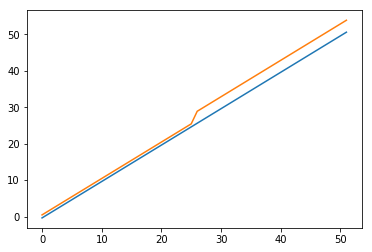

In [46]:
# Naive expected values

df = pd.DataFrame(Y)
df['$D^*$'] = D_star
d0 = df[df['$D^*$'] == 0]
d1 = df[df['$D^*$'] == 1]
del d0['$D^*$'], d1['$D^*$']
d0.mean(axis=0).plot()
d1.mean(axis=0).plot();

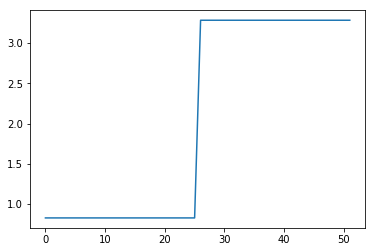

In [47]:
# Naive effect

# We have nobody in the test state before t=25, so we just get the
# Y_0 baseline difference between the D=1 and D=0 groups at t < 25.
# Afterward, we get the difference of E[Y_t|D=1] - E[Y_t|D=0]

df = pd.DataFrame(Y)
df['$D^*$'] = D_star
d0 = df[df['$D^*$'] == 0]
d1 = df[df['$D^*$'] == 1]
del d0['$D^*$'], d1['$D^*$']
(d1.T.mean(axis=1) - d0.T.mean(axis=1)).plot();


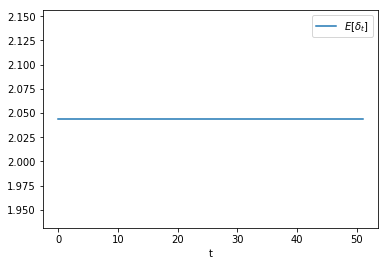

In [48]:
# True Effect

pd.DataFrame({'$E[\delta_t]$': (Y_1 - Y_0).mean(axis=0), 
              't': range(Y_0.shape[1])}).plot(x='t');

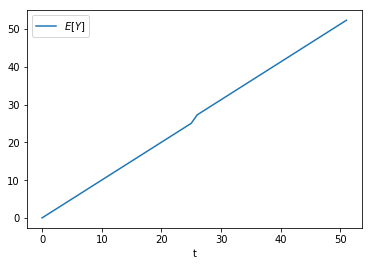

In [49]:
# For completeness, let's also check out the expected outcome over the whole population:

expected_outcome = Y.mean(axis=0)
pd.DataFrame({'$E[Y]$': expected_outcome, 't': range(expected_outcome.shape[0])}).plot(x='t');

In [50]:
# And the number of treated units vs. time:

D.sum(axis=0)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 505., 505., 505., 505., 505., 505., 505.,
       505., 505., 505., 505., 505., 505., 505., 505., 505., 505., 505.,
       505., 505., 505., 505., 505., 505., 505., 505.])

Now, we'll do propensity score matching on Z to match control units to test units to estimate the ATT. Since the confounding is constant with time, we can just match units (otherwise their propensities would vary over time, and matches might change!)

In [51]:
from causality.estimation.parametric import PropensityScoreMatching
import pandas as pd

First, we'll find matches by matching on propensity scored P(D|Z). As usual, we should check the support.

In [52]:
matcher = PropensityScoreMatching()
df = pd.DataFrame({'D': D_star, 'Z': Z, 'id': range(units)})
matcher.score(df, confounder_types={'Z': 'c'}, assignment='D')
treated, matched_controls = matcher.get_control_matches(df[df['D'] == 1], df[df['D'] == 0])


Optimization terminated successfully.
         Current function value: 0.604377
         Iterations 5


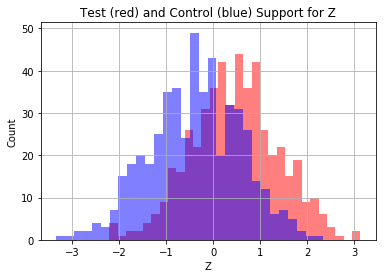

In [53]:
matcher.check_support(df, confounder_types={'Z': 'c'}, assignment='D')

There's some pretty significant non-overlap here, but we'll assume that the propensity score model (the logistic regression) extrapolates well into the non-overlapping region.

Now, we'll put the match data into two different dataframes (numpy's indexing is handy here!)

In [54]:
treated_outcomes = Y[treated.id]
control_outcomes = Y[matched_controls.id]

Then, we'll average the treated and matched control outcomes over all units at each time step, to estimate $E[Y_{1, t}]$ and $E[Y_{0, t}]$:

In [55]:
expected_y_1 = treated_outcomes.mean(axis=0)
expected_y_0 = control_outcomes.mean(axis=0)

We put the resulting time series into a dataframe so we can plot it.

In [56]:
result = pd.DataFrame({'t': range(expected_y_0.shape[0]), 
                      '$E[Y_1]$': expected_y_1, 
                      '$E[Y_0]$': expected_y_0,
                      '$E[\delta]$': expected_y_1 - expected_y_0})

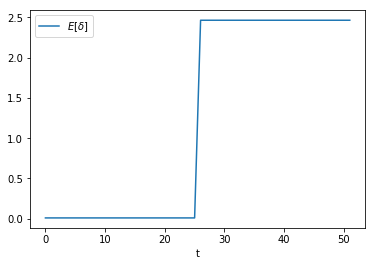

In [57]:
result.plot(x='t', y='$E[\delta]$');

In [58]:
result.tail()

,t,$E[Y_1]$,$E[Y_0]$,$E[\delta]$
47,47,49.907763,47.443453,2.46431
48,48,50.907763,48.443453,2.46431
49,49,51.907763,49.443453,2.46431
50,50,52.907763,50.443453,2.46431
51,51,53.907763,51.443453,2.46431


Compare this with the true ATT, 

In [59]:
df = pd.DataFrame(Y_1 - Y_0)
df['D'] = D_star
df[df['D'] == 1].mean(axis=0).head()

0    2.453882
1    2.453882
2    2.453882
3    2.453882
4    2.453882
dtype: float64

Looks pretty good!

Now, let's handle this when the units aren't treated at the same times. A simple trick is to mask out values you want to ignore when you're conditioning.

In [60]:
units = 3000
time_steps = 52

Z = np.random.normal(size=units)

a_trend = np.arange(0, time_steps, 1)
individual_effects = Z
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_trend + A_indiv


p_d = 1. / (1. + np.exp(-Z))
D_star = np.random.binomial(1, p=p_d)
D = np.zeros(shape=Y_0.shape)
for i in range(units):
    for t in range(time_steps):
        if D_star[i] and t > 0:
            if t == time_steps - 1 or D[i][t-1] == 1:
                D[i][t] = 1
            else:
                D[i][t] = np.random.binomial(1, p=1./float(time_steps))

                    
delta = 2.
Y_1 = Y_0 + delta + A_indiv
Y = (D==1)*Y_1 + (D==0)*Y_0

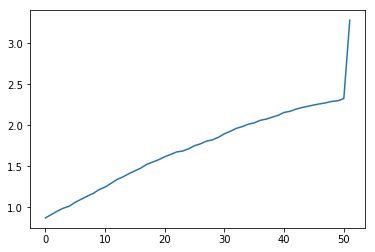

In [61]:
# Naive effect
# Since they all don't start at the same 
# time, we really need to be careful about 
# which units we're averaging over at which 
# times. The old way doesn't work:

df = pd.DataFrame(Y)
df['$D^*$'] = D_star
d0 = df[df['$D^*$'] == 0]
d1 = df[df['$D^*$'] == 1]
del d0['$D^*$'], d1['$D^*$']
(d1.T.mean(axis=1) - d0.T.mean(axis=1)).plot();


This is because many of the $D^* = 1$ units are still in the $D=0$ state in the earlier times, and more and more go into the $D=1$ state over time. That's why you see the gradual ramp-up in the effect. 

The correct way to do this is to mask out the $D^*=1$ users who are still in the $D=0$ state at each time step when we take the averages.

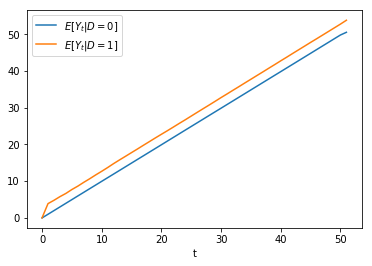

In [62]:
# Naive expected values

mask_0 = (D==1)  # mask out the D=1 values.
mask_1 = (D==0)  # mask out the D=0 values.
Y_given_0 = np.ma.array(data=Y,
                        mask=mask_0,
                        fill_value=np.nan).mean(axis=0)
Y_given_1 = np.ma.array(data=Y,
                        mask=mask_1,
                        fill_value=np.nan).mean(axis=0)
df = pd.DataFrame({'$E[Y_t|D=0]$': Y_given_0.data,
                   '$E[Y_t|D=1]$': Y_given_1.data,
                   '$\delta_t$': Y_given_1.data - Y_given_0.data,
                   't': range(Y.shape[1])})
df.plot(x='t', y=['$E[Y_t|D=0]$', '$E[Y_t|D=1]$']);

This gives us a nicer looking naive effect:

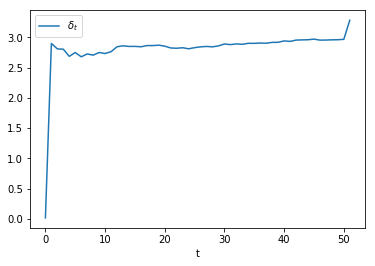

In [63]:
df.plot(x='t', y='$\delta_t$');

There's a good bit of estimation noise at the beginning. The starting value is 0, since there are no units in the 1 state. 

Now, we can be more careful about propensity score matching.

In [64]:
matcher = PropensityScoreMatching()
df = pd.DataFrame({'D': D_star, 'Z': Z, 'id': range(units)})
matcher.score(df, confounder_types={'Z': 'c'}, assignment='D');
treated, matched_controls = matcher.get_control_matches(df[df['D'] == 1], df[df['D'] == 0]);


Optimization terminated successfully.
         Current function value: 0.586570
         Iterations 6


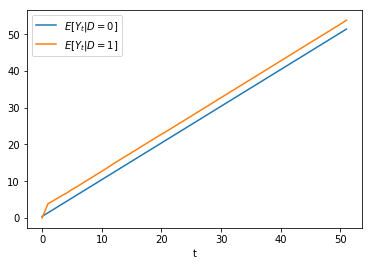

In [65]:
treated_outcomes = Y[treated.id]
control_outcomes = Y[matched_controls.id]
D_treated = D[treated.id]
D_control = D[matched_controls.id]

mask_0 = (D_control==1)  # mask out the D=1 values.
mask_1 = (D_treated==0)  # mask out the D=0 values.
Y_given_0 = np.ma.array(data=control_outcomes,
                        mask=mask_0,
                        fill_value=np.nan).mean(axis=0)
Y_given_1 = np.ma.array(data=treated_outcomes,
                        mask=mask_1,
                        fill_value=np.nan).mean(axis=0)
df = pd.DataFrame({'$E[Y_t|D=0]$': Y_given_0.data,
                   '$E[Y_t|D=1]$': Y_given_1.data,
                   '$\delta_t$': Y_given_1.data - Y_given_0.data,
                   't': range(Y.shape[1])})
df.plot(x='t', y=['$E[Y_t|D=0]$', '$E[Y_t|D=1]$']);

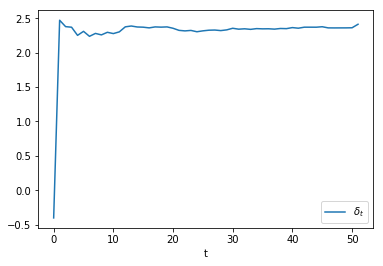

In [66]:
df.plot(x='t', y='$\delta_t$');

We get the correct ATT!